### Robot Learning

### Assignment 3

Solutions are due on 06.05.2025 before the lecture.

### Introduction

Please familiarize yourself with the environment for this assignment sheet by examining the following code cell, which simulates an agent attempting to travers a challenging racetrack by randomly accelerating or decelerating its car at each time step.

In [1]:
# for this weeks helper function, we need skimage. Install it by uncommenting and running the line below
# make sure that you have started the jupyter notebook in your rl_25 python env
!pip install scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.9 MB 32.7 MB/s eta 0:00:01
   -------- ------------------------------- 2.6/12.9 MB 33.6 MB/s eta 0:00:01
   ------------ --------------------------- 3.9/12.9 MB 31.1 MB/s eta 0:00:01
   ------------------ --------------------- 6.1/12.9 MB 38.7 MB/s eta 0:00:01
   -------------------------- ------------- 8.5/12.9 MB 39.0 MB/s eta 0:00:01
   --------------------------------- ------ 10.9/12.9 MB 43.7 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 43.7 MB/s eta 0:00:01
   ---------------------------------------  12.9/12.9 MB 46.7 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 38.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/315.8 kB ? eta -:--:--
   --------------------------------------- 315.8/315.8 kB 20.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/226.8 kB ? eta -:--:--
  

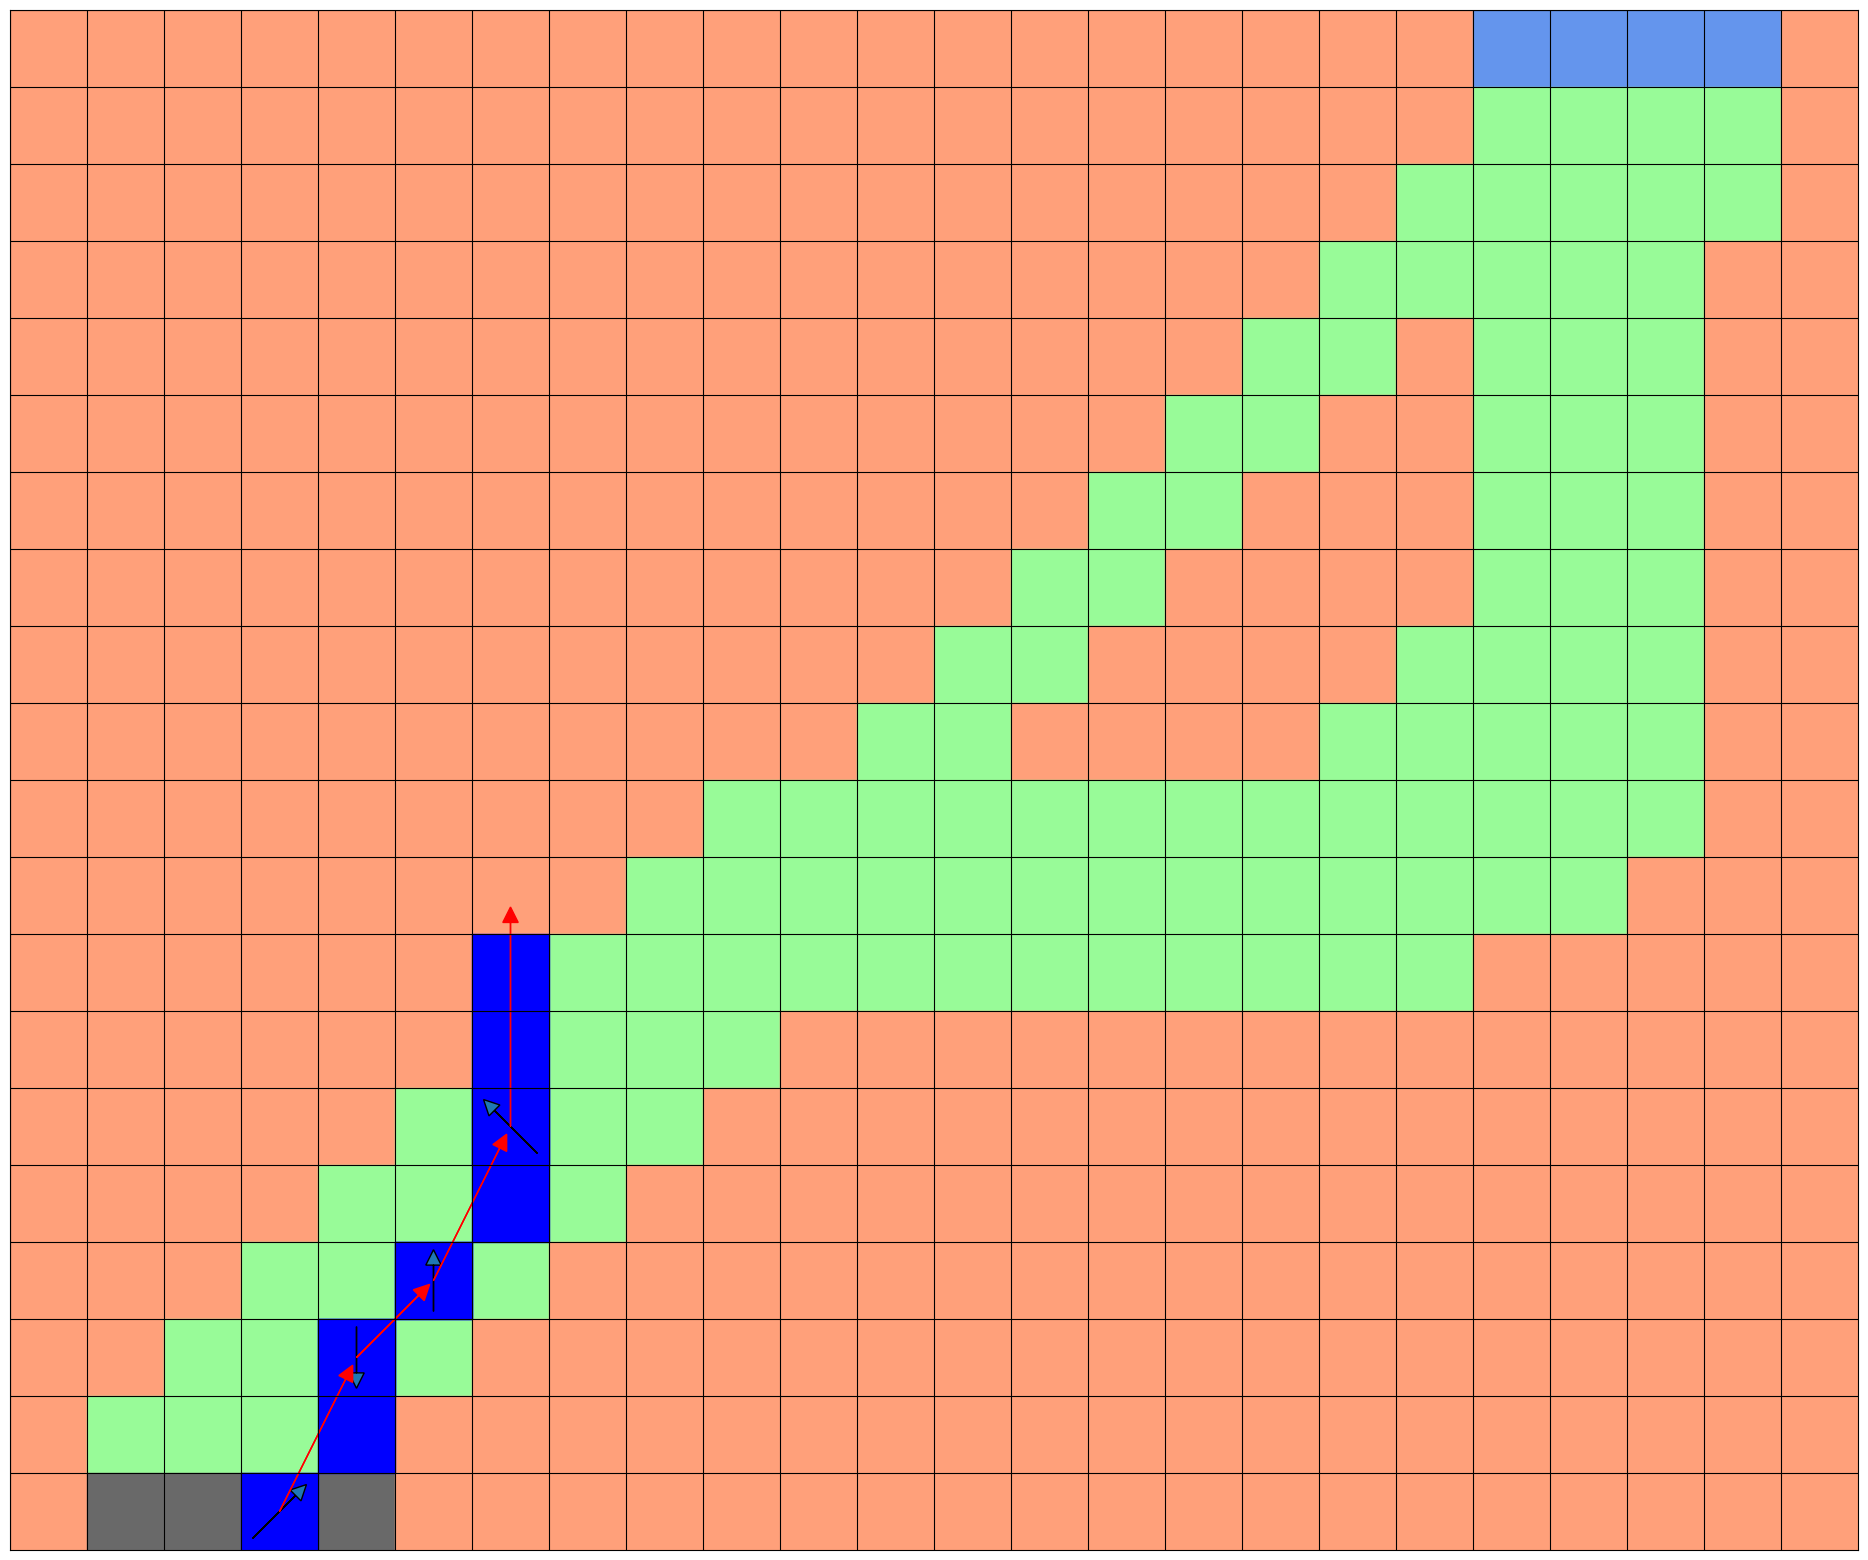

In [ ]:
import numpy as np
# get the required helper class and visualization function
from helpers.utils import env, drawTrajectory, racetrack

# this makes sure that our description of the episode visualization makes sense
np.random.seed(2025)

# create a racing environment
racer = env()
# reset the agent to one of the 4 starting cells at random
# do this before each new episode
racer.reset()
# you can also manually set the agent position if you want to examine its behaviour there
# for example: racer.setPosition(19,1)
# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions = []
moves = []
velocities = []

# these following methods do what you would expect
# v is an integer in [0, 35] representing an encoded velocity
v = racer.getVelocity()
# y, x are both integers, together, they represent the agent location
y, x = racer.getPosition()
# together (y, x, v) corresponds to the state of the environment

# simulate until the episode is over
while not done:
    # which actions are possible at the current velocity?
    # the actions are encoded to integers in [0,8]
    possibleActions = racer.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions)
    # save the action
    actions.append(a)
    # execute the action using the step function
    # y, x, v are new positions and velocities
    # done is the flag whether the episode is over
    # travel details exactly which cells the agent traveled through
    y, x, v, r, done, travel = racer.step(action = a, deviation=False)
    # save the velocities
    velocities.append(v)
    # save the cells that the agent most recently passed through
    # they are only needed for visualization
    moves.append(travel)

# use the helper function to display how the episode went

drawTrajectory(moves, actions, velocities)



The agent enters the section on one of the gray cells at the bottom. Its initial velocity is one cell per time step into the upward direction.

Actions are to increase or decrease its velocity components by one or to leave it unchanged. To clarify, the actions are not to set a velocity, but to accelerate or decelerate. The velocity is thus part of the agent's state, the available actions are accelerations within the physical limitations of the vehicle that the agent is driving.

Both velocity components are restricted to be nonnegative and their sum must be at least 1 and cannot exceed 6. This constrains the available actions based on the agent's current velocity.

The rewards are $0.1$ for each step that the agent stays on the track, which is colored green. The reward is $−16$ if the agent drives into the crash barriers marked in red. The episode ends when the agent crashes or when it succesfully exits the section by driving onto the blue line at the top-right of the grid, yielding a reward of $14$.

As an output to the cell above, you get a visualization of the agent's path through the race track section. You can see several cells marked in dark blue. These are the grid cells that the agent passed through. Between two time steps, they are calculated by a line drawing algorithm given the current position and velocity of the agent, as well as the acceleration it selected. This acceleration is represented by the arrows with the blue tips. In some cases, a cell will instead contain a circle. This represents the action of no acceleration or deceleration at all, which means that the velocity stays the same as in the previous time step. The red arrows show the velocity of the agent at a certain step after the acceleration the agent selected is added to it. 

For example, at the very start, the agent has the initial velocity of one cell per step towards the top of the grid. It chooses to accelerate diagonally and thus moves two cells upwards and one to the right in total. Then it chooses to decelerate vertically. Thus, the resulting velocity, represented by the second diagonal red arrow, points one cell towards the top and one cell towards the right. The agent then accelerates by one unit towards the top and towards the right. Thus, the next red arrow representing the velocity now spans two cells. Then, the agent steers towards the right while accelerating vertically, so the episode ends with a direct crash into the barriers.

## Task 3.1)

Compute  $V(s)$  for each grid cell on the racetrack using constant-$\alpha$ every-visit Monte Carlo Policy Evaluation for  $10000$ episodes of a policy that uniformly chooses one of the available actions. The update of the state value for this algorithm is given by modifying the incremental update of $\operatorname{average}(Returns(s))$ to

$$V(s_t) = V(s_t) + \alpha [R_t - V(s_t)],$$

where $R_t$ is the actual return following time $t$.

Initialize $V(s)$ with zeros, use $\alpha=0.18$ and also print and visualize the resulting state values!

<div style="text-align: right; font-weight:bold"> 5 Points </div>

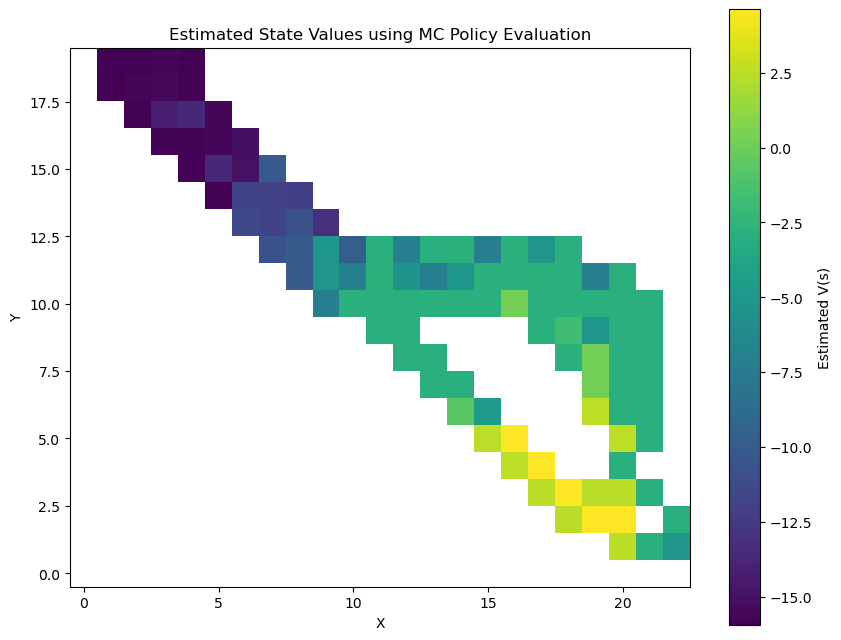

In [11]:
import numpy as np
from helpers.utils import env
from collections import defaultdict
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(2025)

# Create racetrack environment
racer = env()

# Parameters
alpha = 0.18
num_episodes = 10000

# Initialize value function V(s) as a dictionary with default 0
V = defaultdict(float)

# Run Monte Carlo policy evaluation
for episode in range(num_episodes):
    # Reset environment and store trajectory
    racer.reset()
    trajectory = []
    done = False
    
    while not done:
        state = (*racer.getPosition(), tuple(racer.getVelocity()))
        actions = racer.getAvailableActions()
        action = np.random.choice(actions)
        y, x, v, r, done, travel = racer.step(action=action, deviation=False)
        trajectory.append((state, r))
    
    # Compute return from end to start
    G = 0
    visited = set()
    for state, reward in reversed(trajectory):
        G += reward
        if state not in visited:
            visited.add(state)
            V[state] += alpha * (G - V[state])

# Create a 2D array of value estimates for visualization (take max over velocities)
ys = [s[0] for s in V.keys()]
xs = [s[1] for s in V.keys()]
grid_height = max(ys) + 1
grid_width = max(xs) + 1

V_grid = np.full((grid_height, grid_width), np.nan)

for (y, x, v), value in V.items():
    if np.isnan(V_grid[y, x]):
        V_grid[y, x] = value
    else:
        V_grid[y, x] = max(V_grid[y, x], value)

# Visualize the estimated values


plt.figure(figsize=(10, 8))
im = plt.imshow(V_grid, cmap='viridis', origin='upper')
plt.colorbar(im, label='Estimated V(s)')
plt.title('Estimated State Values using MC Policy Evaluation')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.show()


## Task 3.2)

Compute the optimal policy using on-policy Monte Carlo control for $100000$ iterations. Initalize $Q(s,a)$ with zeros, use $\varepsilon=0.12$ for action selection and incrementally update the state-action values towards the every-visit sample average  return by using the update rule 

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha(s_t,a_t) [R_t - Q(s_t,a_t)],$$

where $R_t$ is the actual return following time $t$. 

The adaptive step size is $\alpha(s_t,a_t) := \frac{1}{N(s_t,a_t)+1}$, with $N(s_t,a_t)$ the number of times the value of this state-action pair has been updated.

After training, use our helper function to show one episode for each of the four possible starting positions.

<div style="text-align: right; font-weight:bold"> 10 Points </div>

In [12]:
# for convenience, these are the cells that the agent can start in
startingGrid = [(19,x) for x in np.arange(1,5)]

# your code goes here

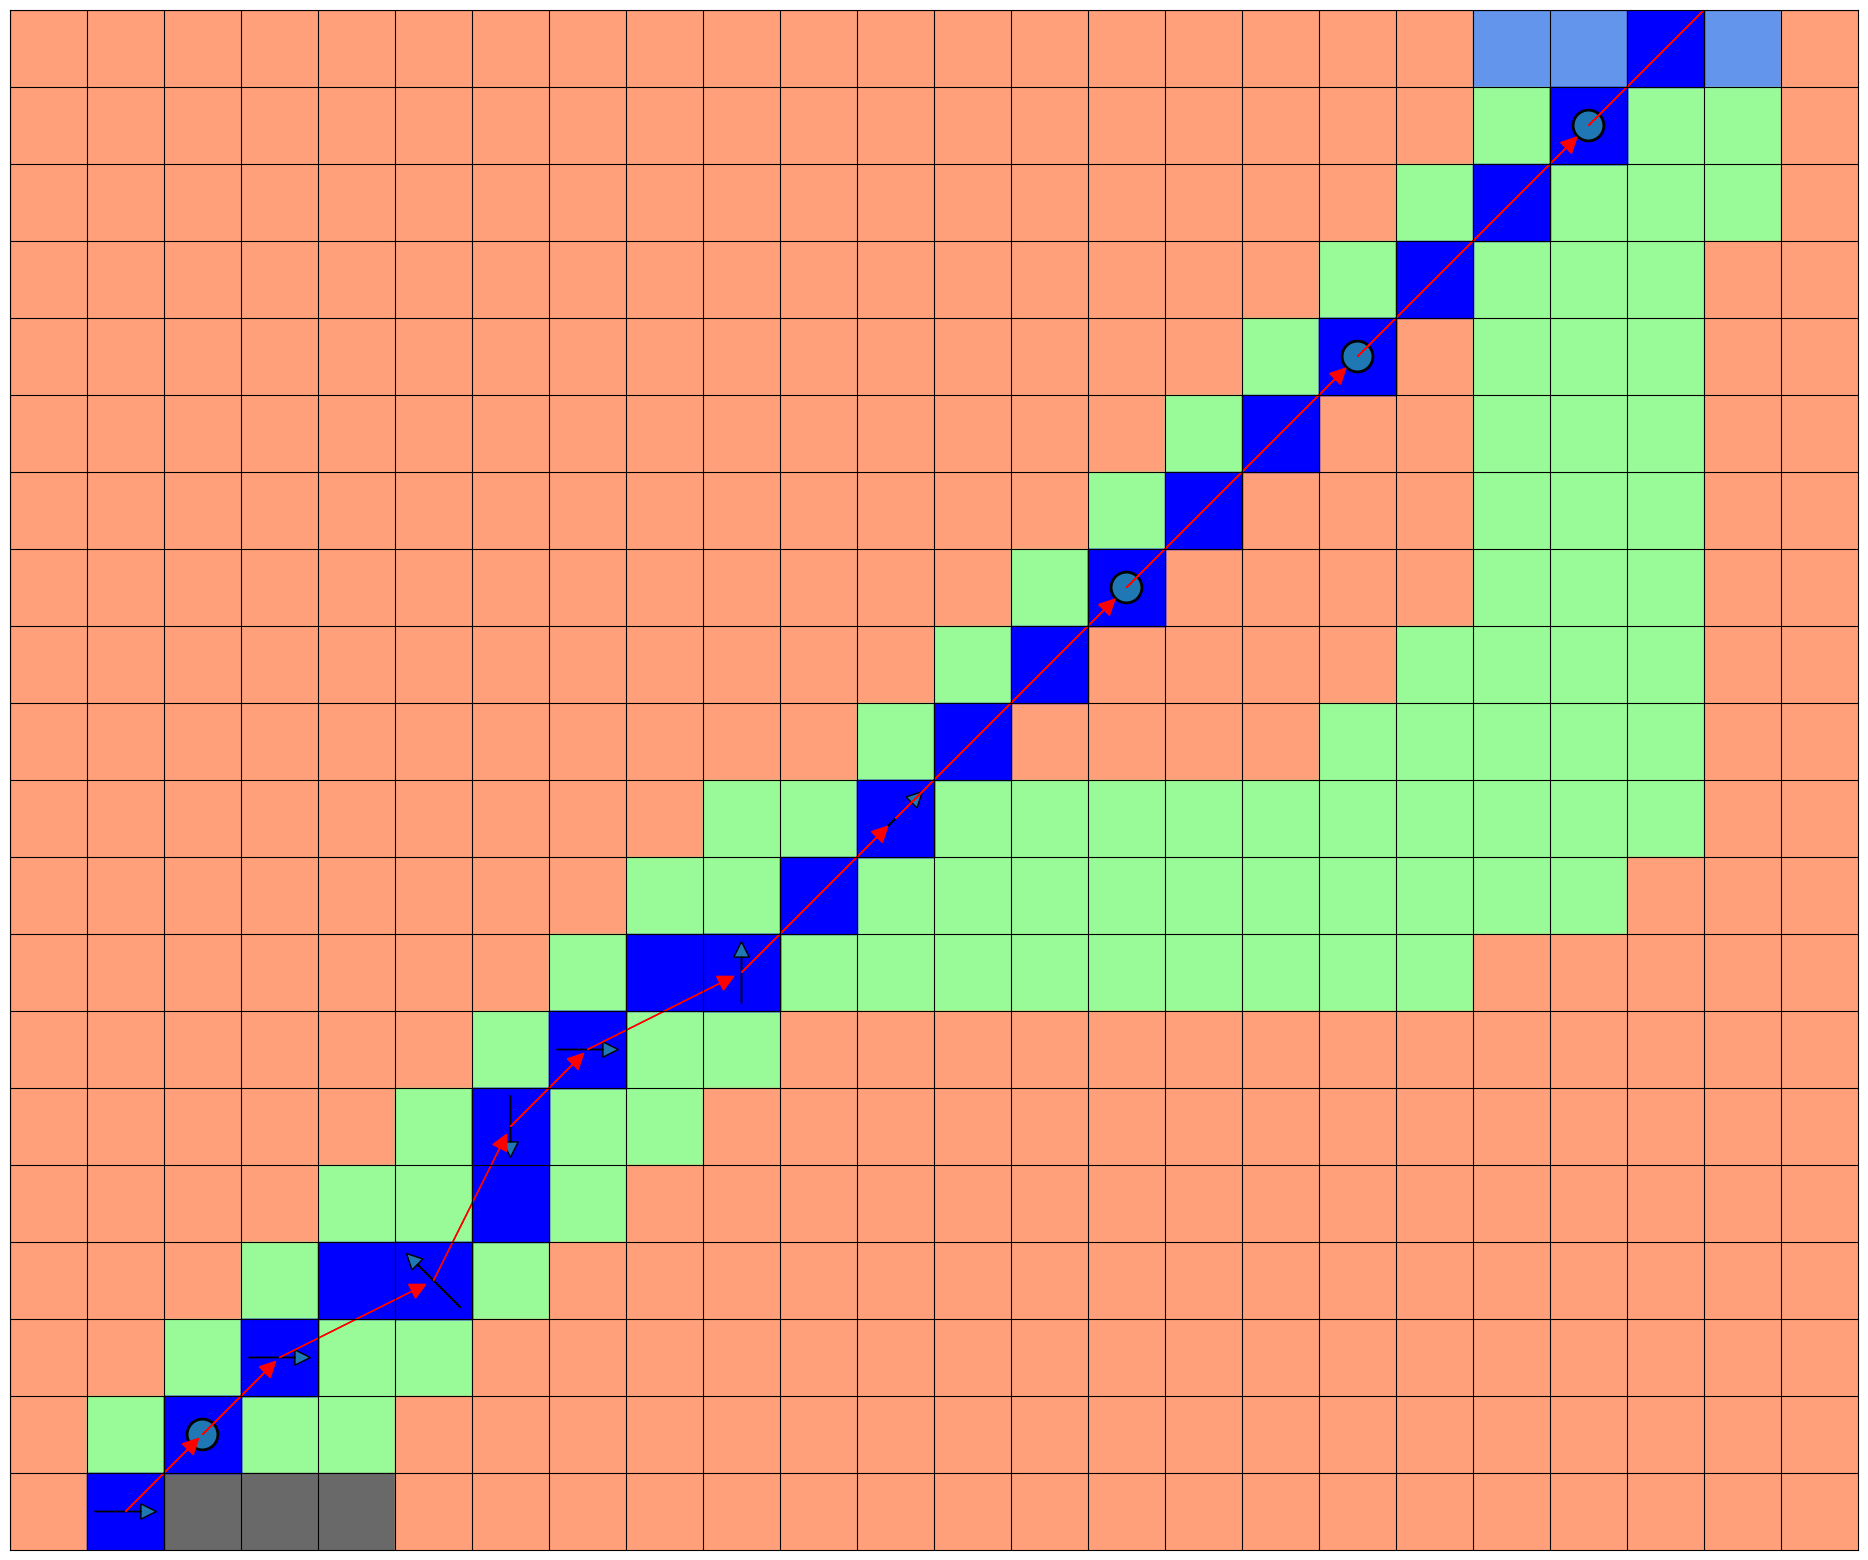

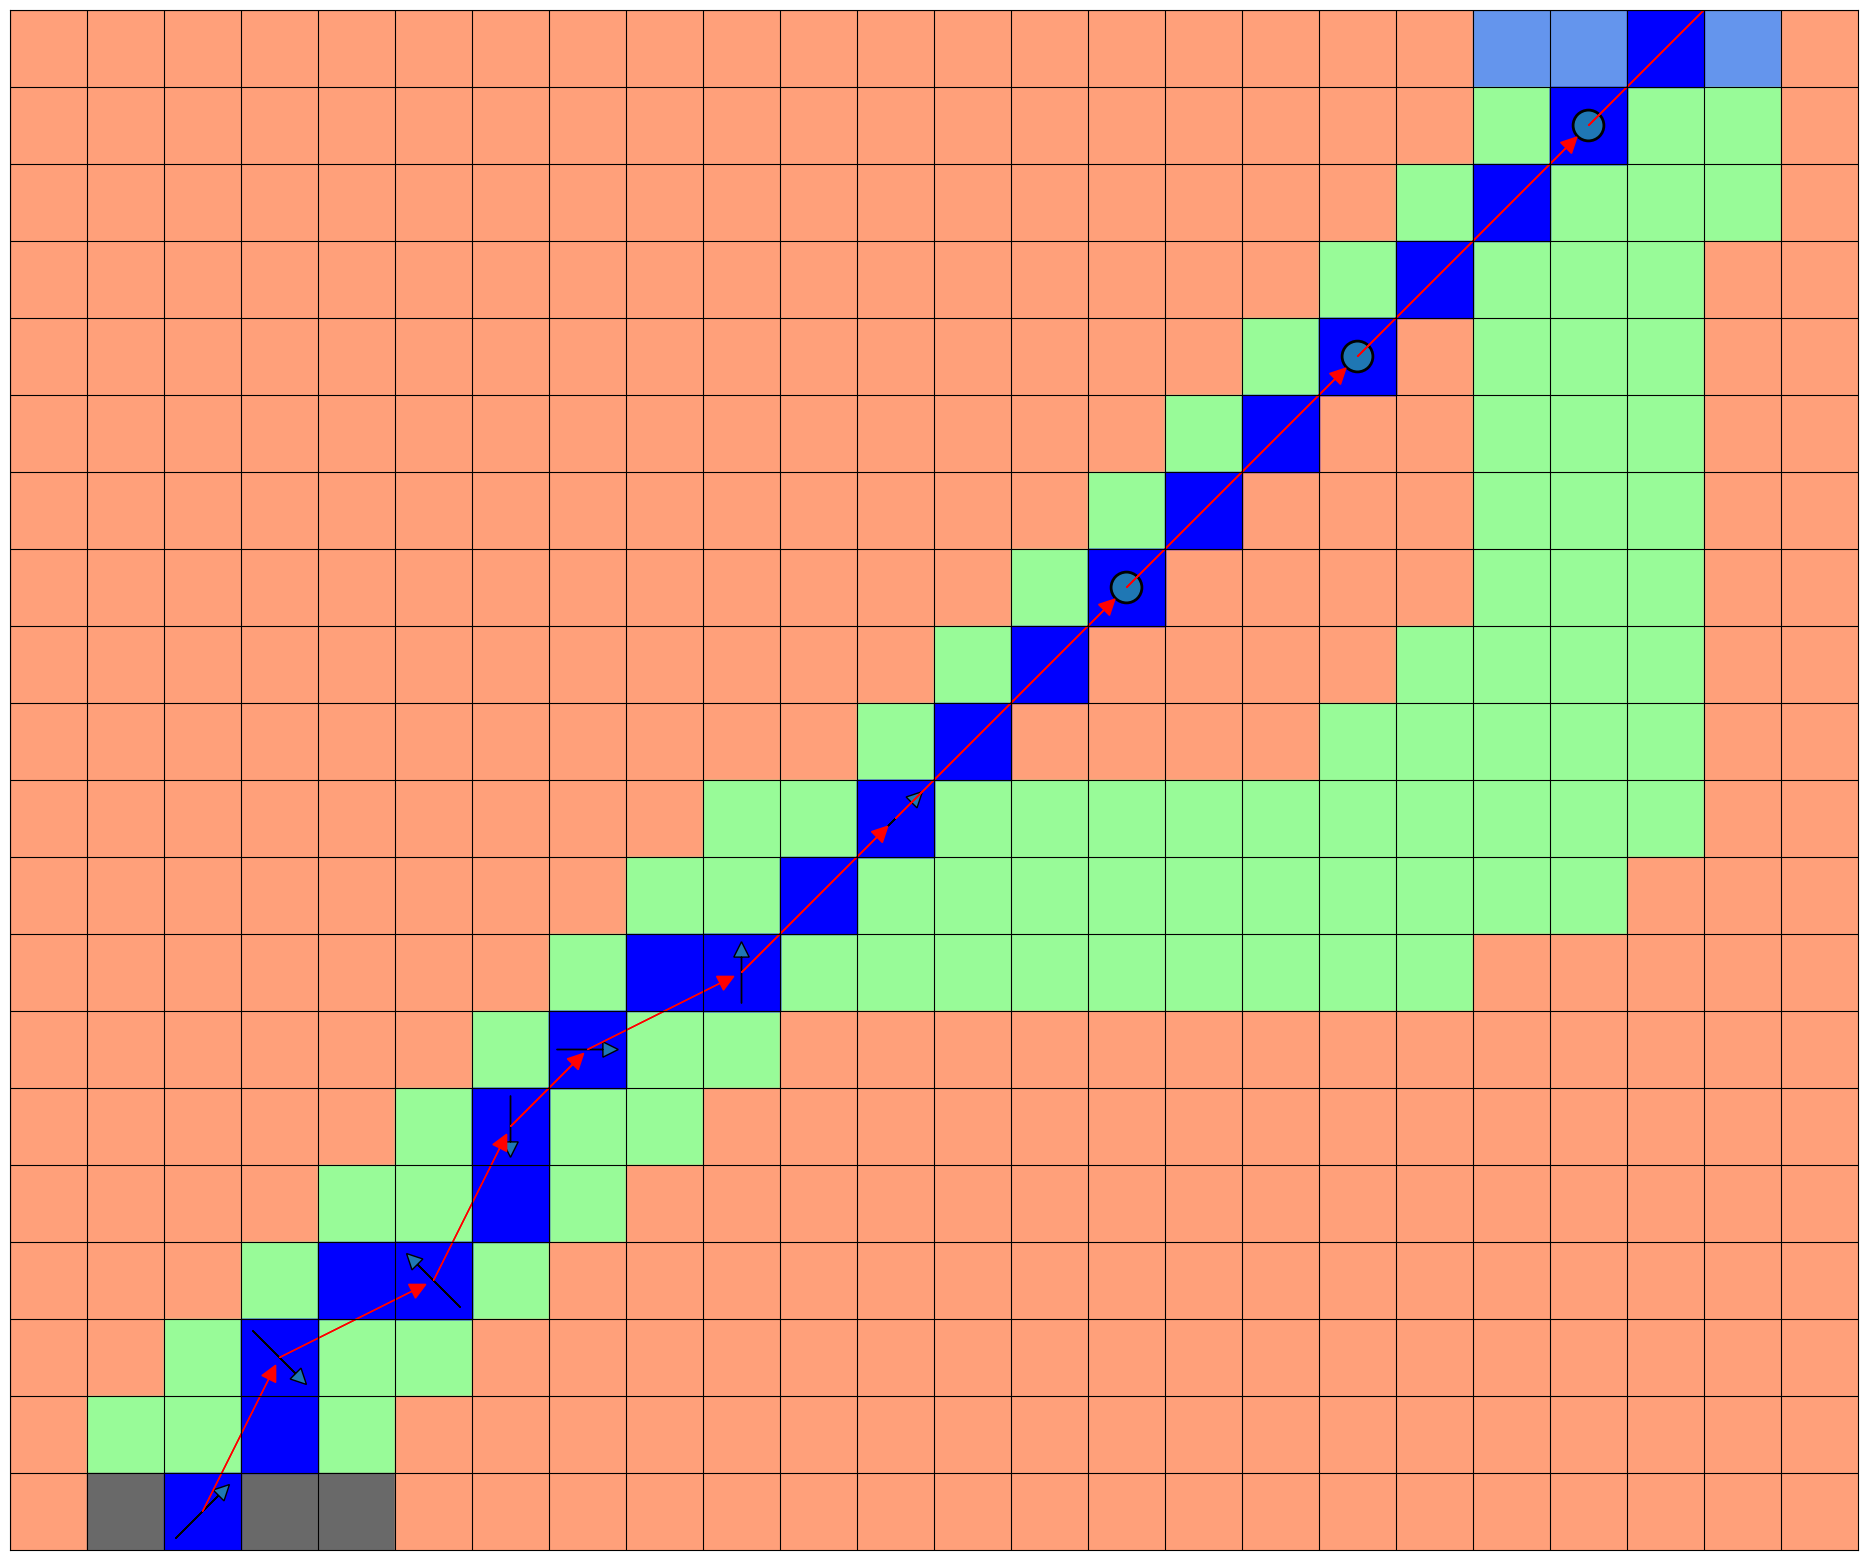

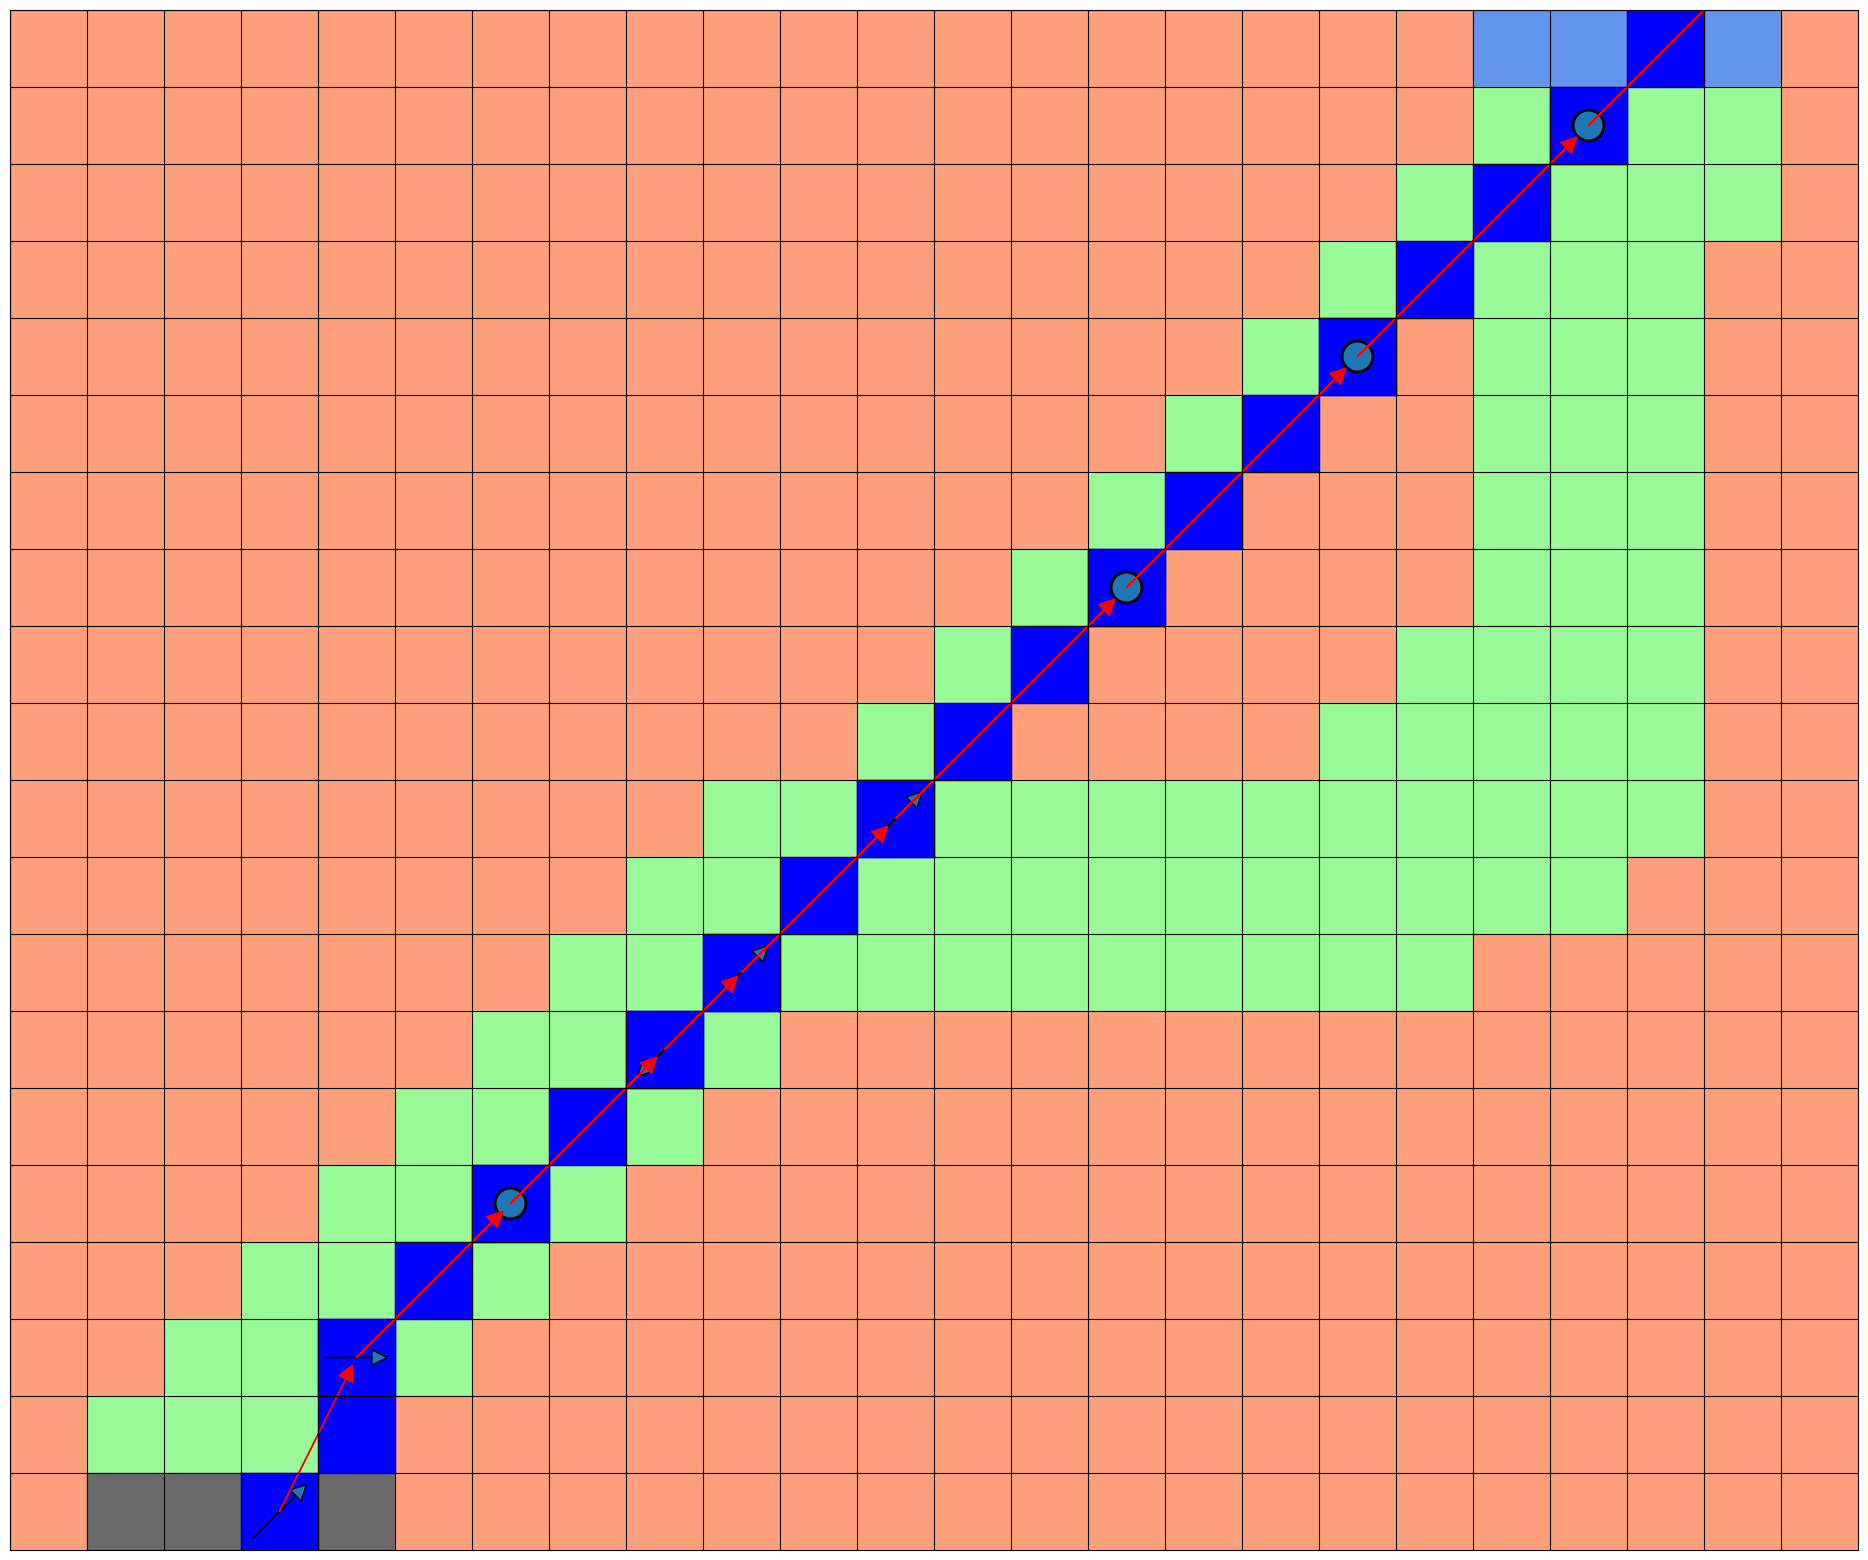

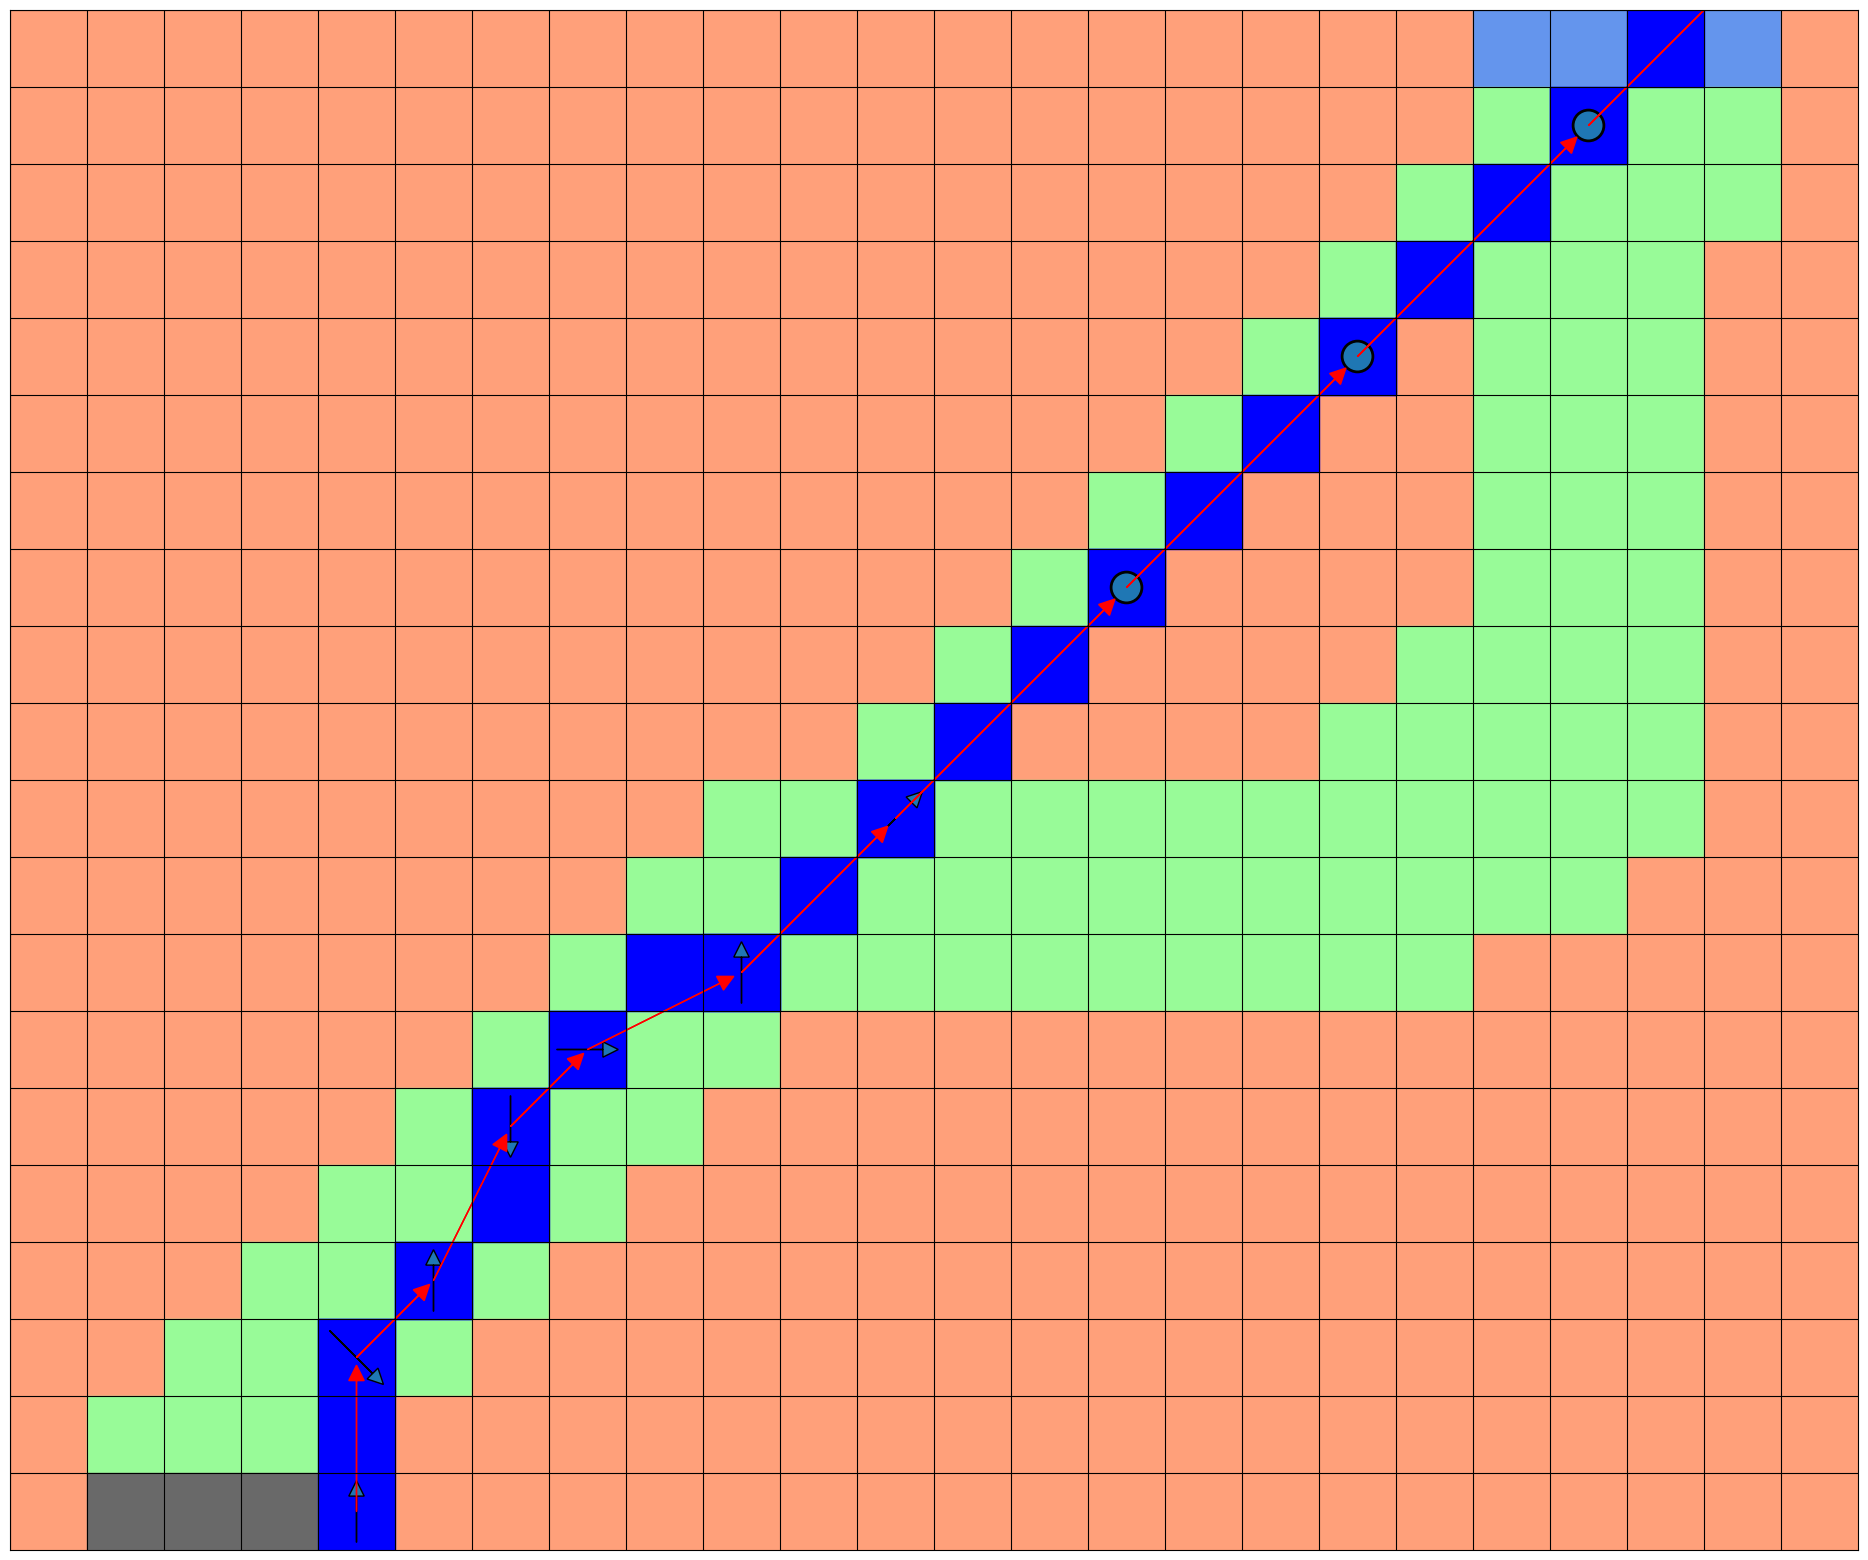

In [13]:
import numpy as np
from collections import defaultdict
from helpers.utils import env, drawTrajectory

np.random.seed(2025)

# Create racetrack environment
racer = env()

# Hyperparameters
num_episodes = 100000
epsilon = 0.12

# Track Q(s, a) and visit counts
Q = defaultdict(float)
N = defaultdict(int)

# For storing optimal policy
policy = {}

# ε-greedy action selection
def epsilon_greedy(state, possible_actions):
    if np.random.rand() < epsilon:
        return np.random.choice(possible_actions)
    #  pick best Q(s, a)
    q_vals = [Q[(state, a)] for a in possible_actions]
    max_val = max(q_vals)
    best_actions = [a for a, val in zip(possible_actions, q_vals) if val == max_val]
    return np.random.choice(best_actions)

# Monte Carlo control loop
for episode in range(num_episodes):
    racer.reset()
    trajectory = []
    done = False

    while not done:
        state = (*racer.getPosition(), tuple(racer.getVelocity()))
        actions = racer.getAvailableActions()
        action = epsilon_greedy(state, actions)
        y, x, v, r, done, travel = racer.step(action=action, deviation=False)
        trajectory.append((state, action, r))

    # Calculate returns and update Q
    G = 0
    visited = set()
    for state, action, reward in reversed(trajectory):
        G += reward
        if (state, action) not in visited:
            visited.add((state, action))
            N[(state, action)] += 1
            alpha = 1 / N[(state, action)]
            Q[(state, action)] += alpha * (G - Q[(state, action)])

# Extract greedy policy from Q
for (state, action), value in Q.items():
    if state not in policy or Q[(state, action)] > Q[(state, policy[state])]:
        policy[state] = action

# Visualize optimal trajectories for four starting positions
startingGrid = [(19, x) for x in np.arange(1, 5)]

for start in startingGrid:
    racer.reset()
    racer.setPosition(*start)
    done = False
    actions = []
    moves = []
    velocities = []

    while not done:
        state = (*racer.getPosition(), tuple(racer.getVelocity()))
        possible_actions = racer.getAvailableActions()
        if state in policy and policy[state] in possible_actions:
            action = policy[state]
        else:
            action = np.random.choice(possible_actions)
        actions.append(action)
        y, x, v, r, done, travel = racer.step(action=action, deviation=False)
        velocities.append(v)
        moves.append(travel)

    drawTrajectory(moves, actions, velocities)


## Task 3.3)

By setting *deviation* to *True* in the step function, the agent randomly moves one cell too far in either the horizontal or vertical direction. For this scenario, compute the optimal policy, again using on-policy Monte Carlo control for $100000$ iterations. 

Initialize the algorithm using the results from the previous task, but use a constant step size $\alpha = 0.18$.

After training, use our helper function to show one episode for each of the four possible starting positions, but set *deviation* to *False* again to show the agent's intended trajectory.

<div style="text-align: right; font-weight:bold"> 5 Points </div>

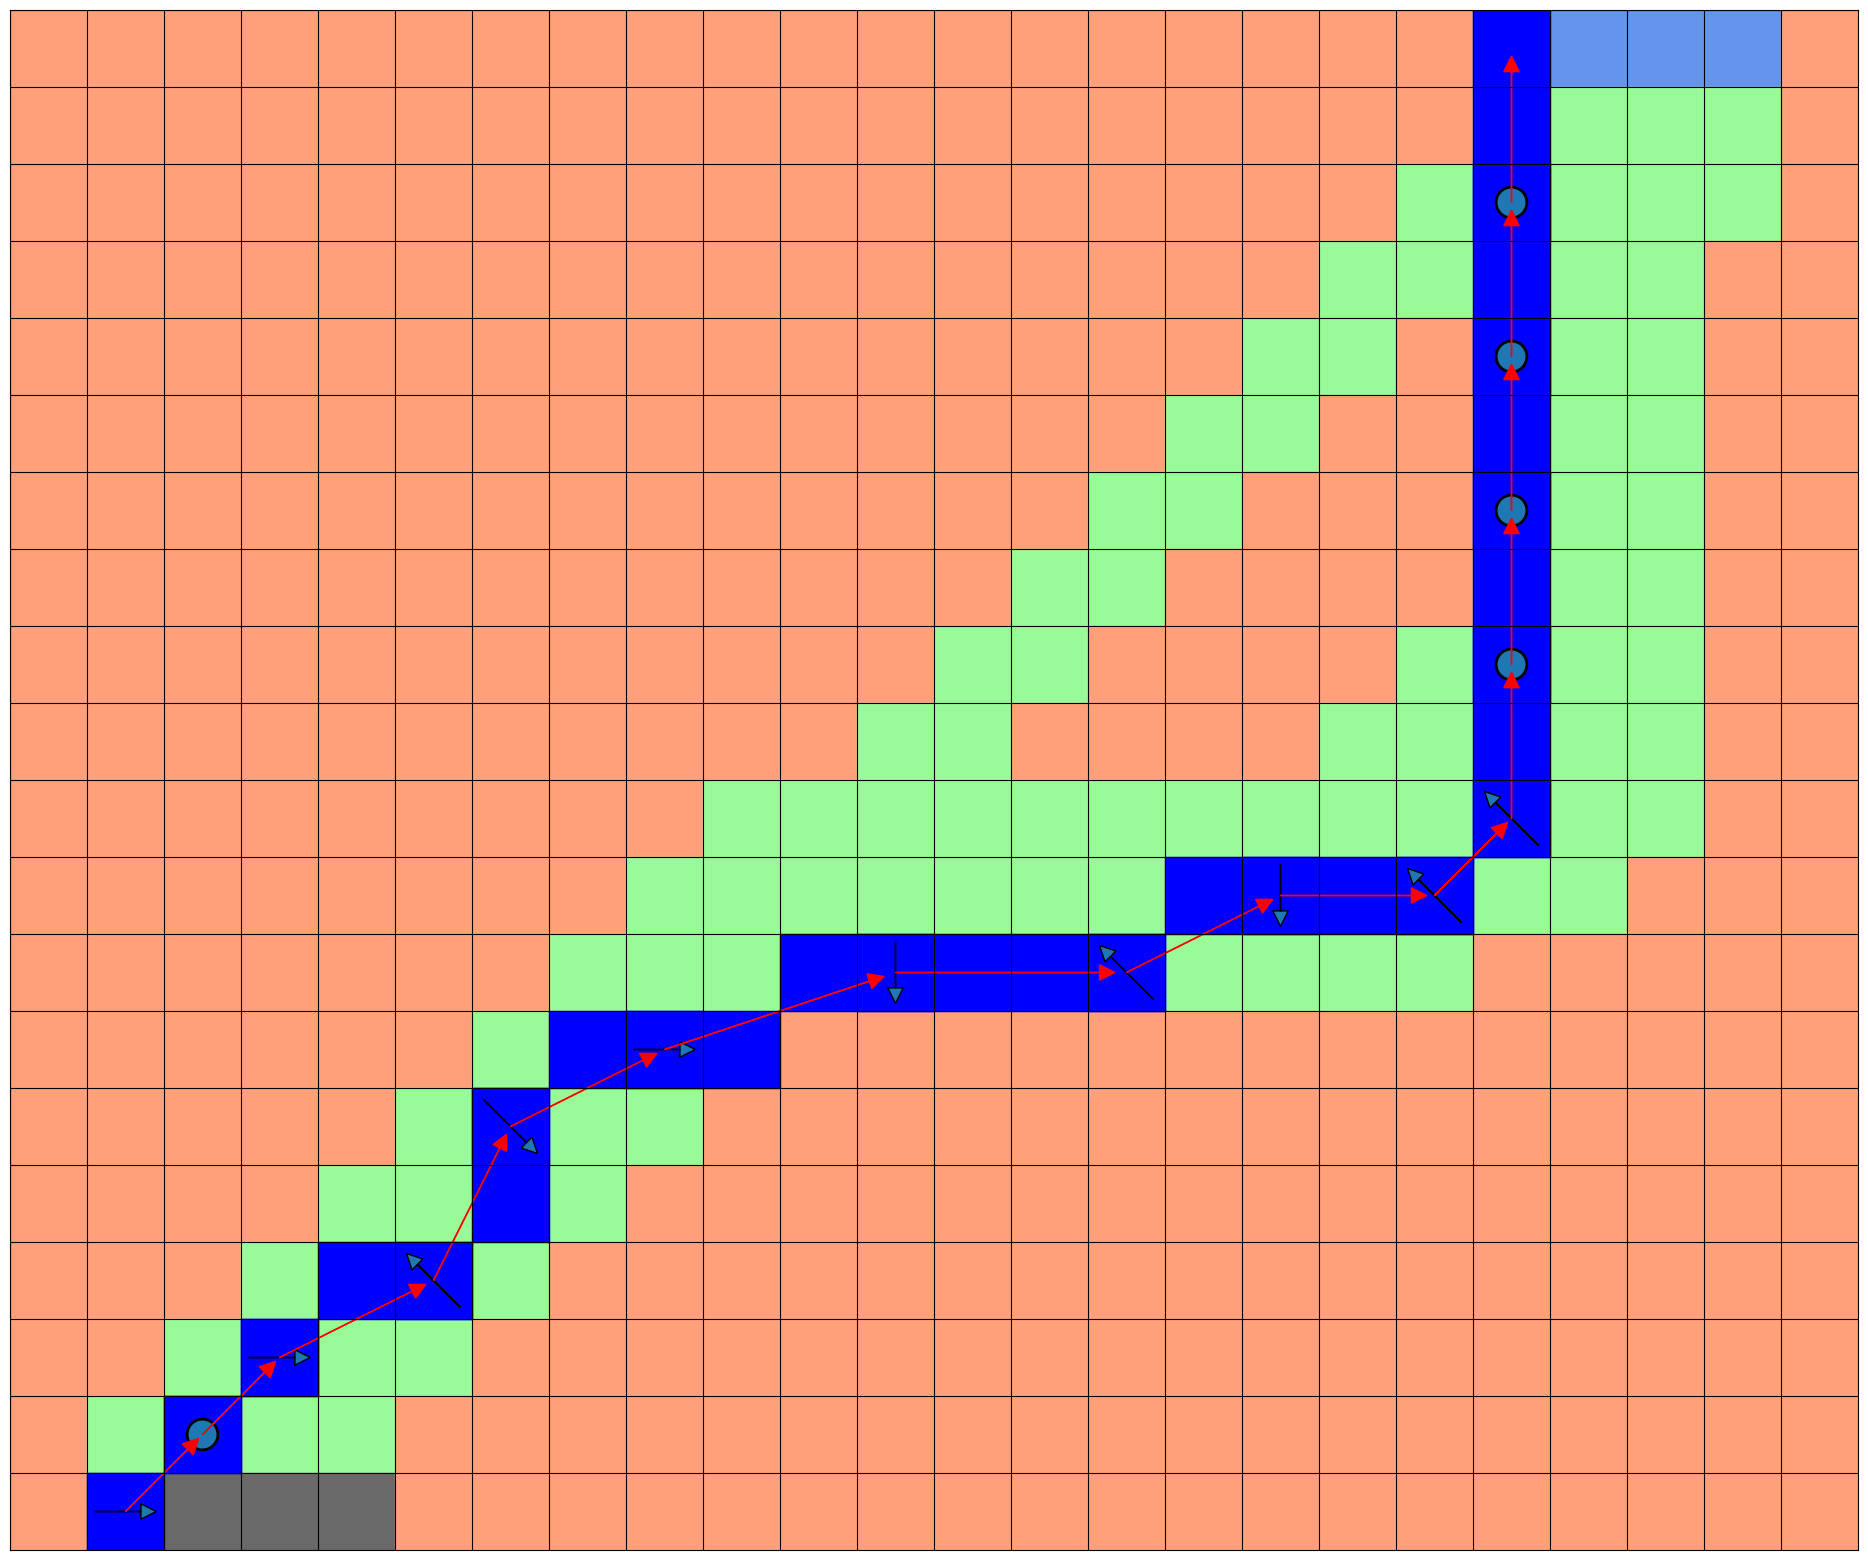

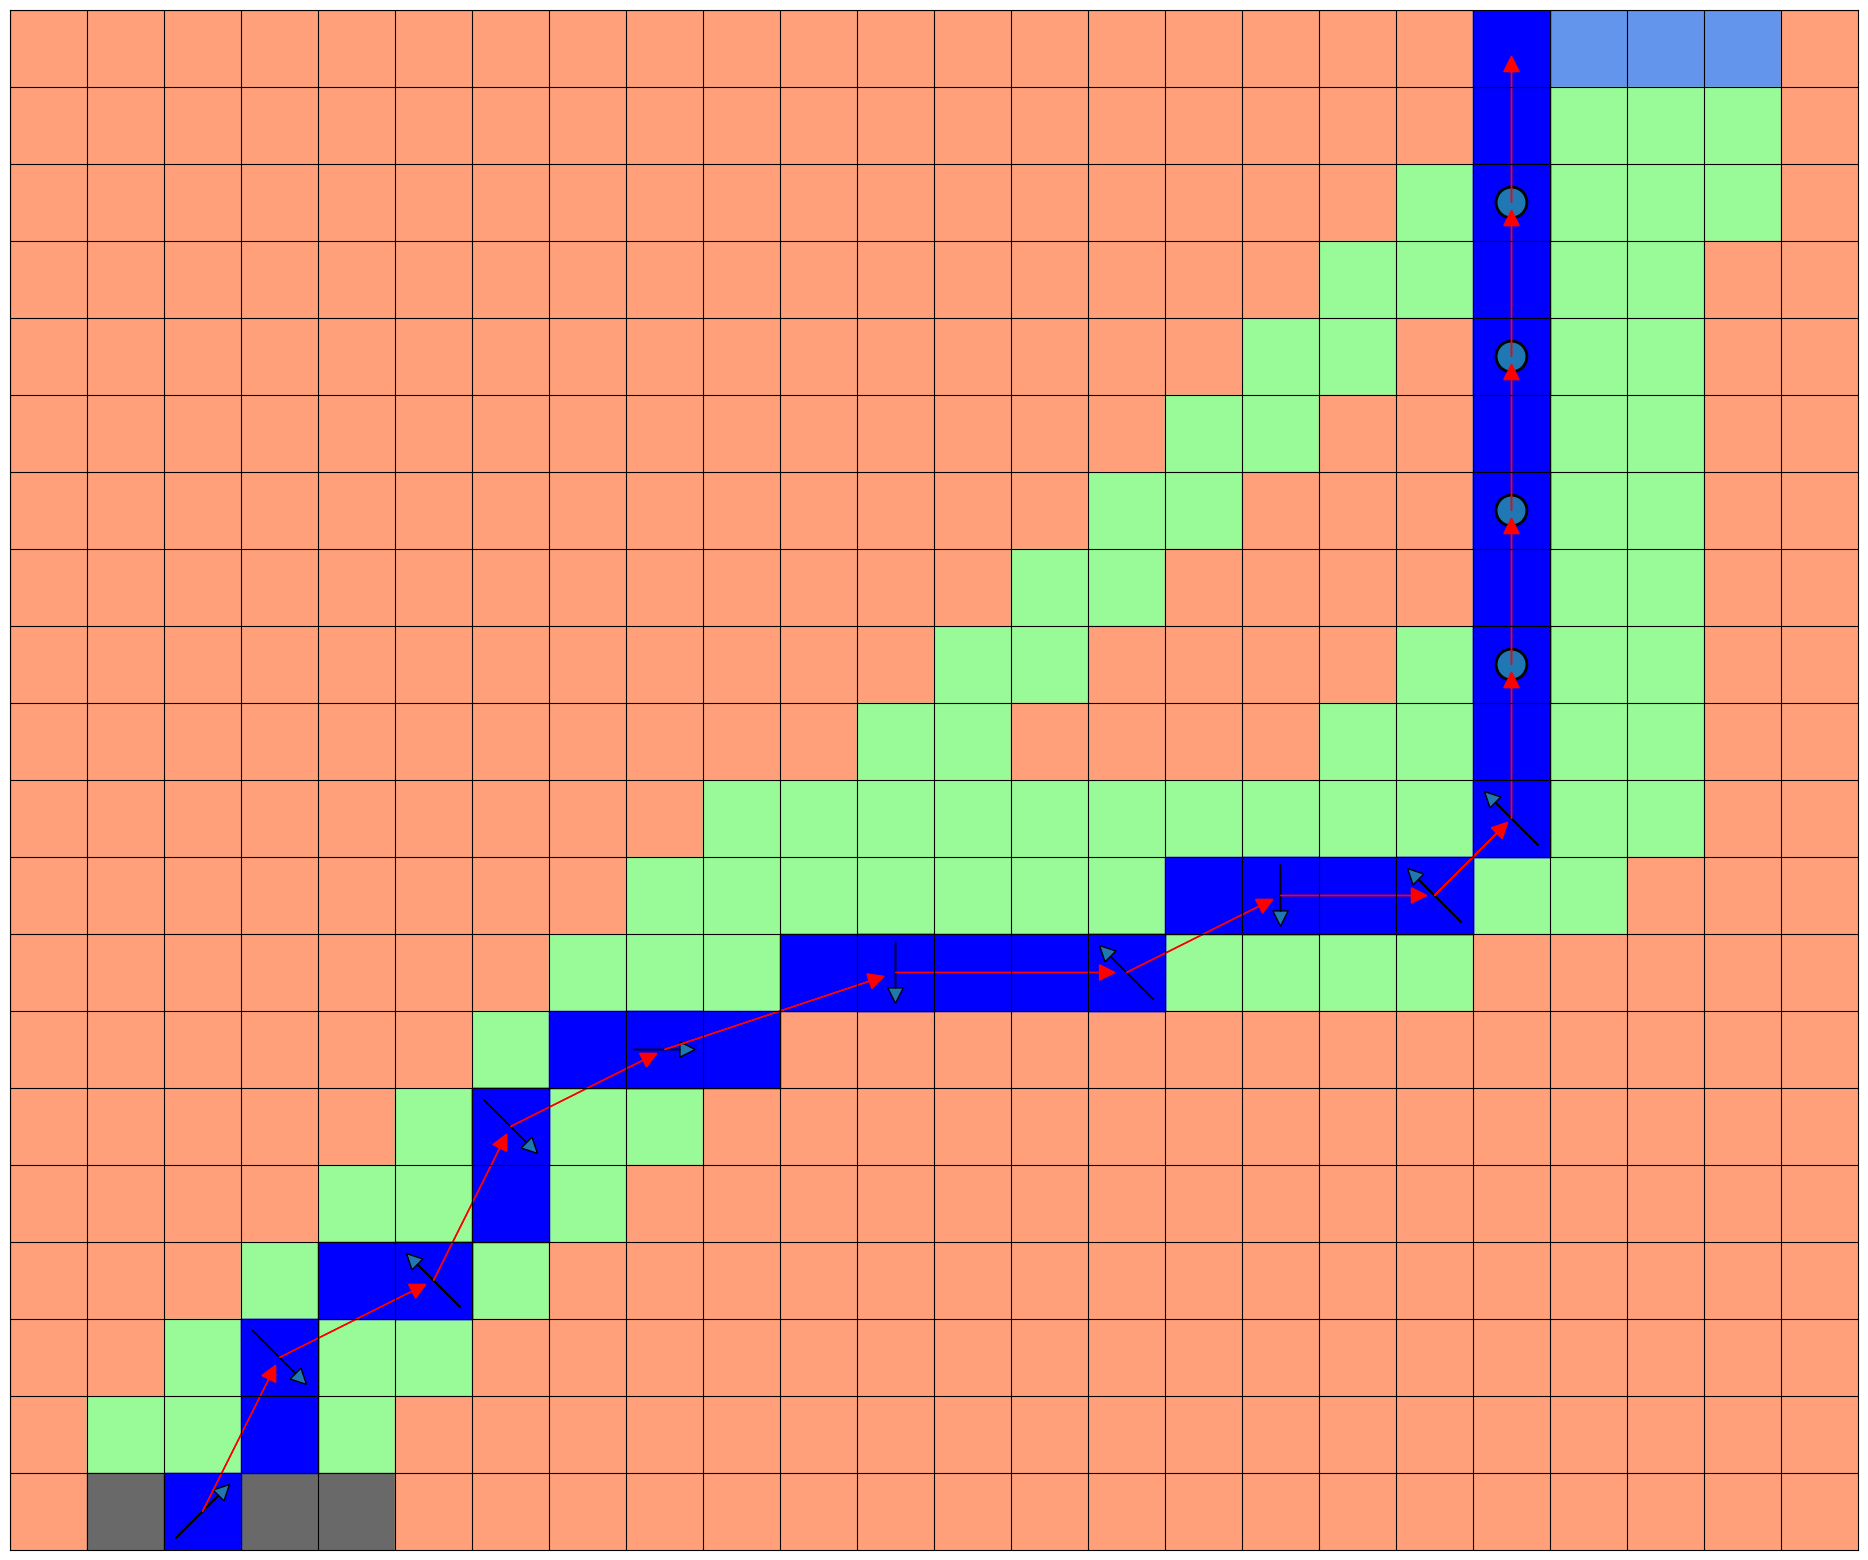

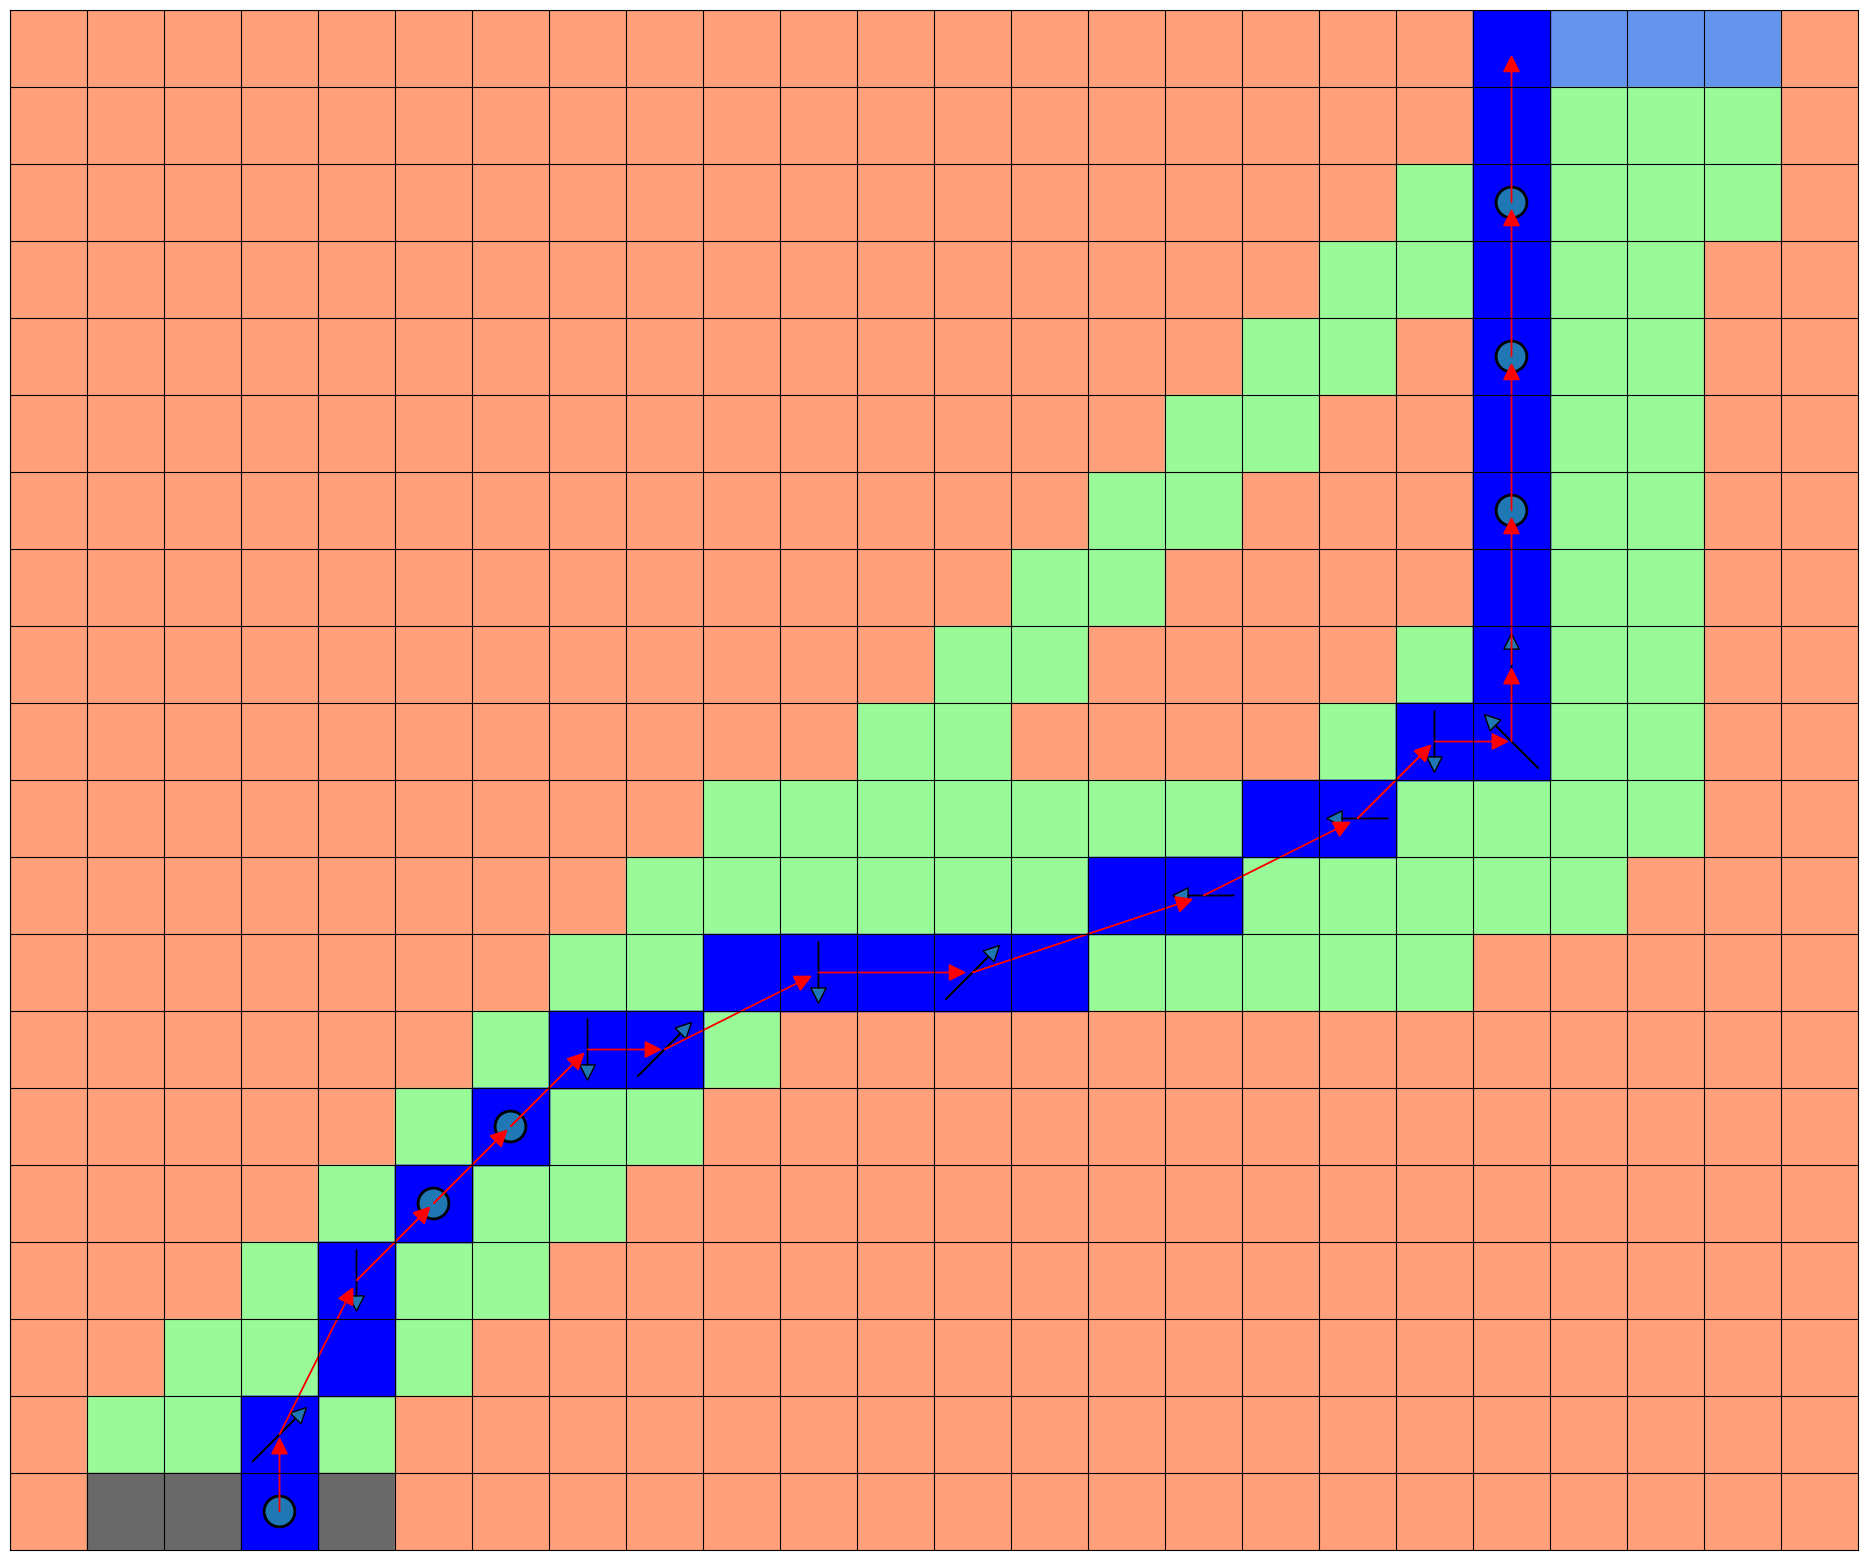

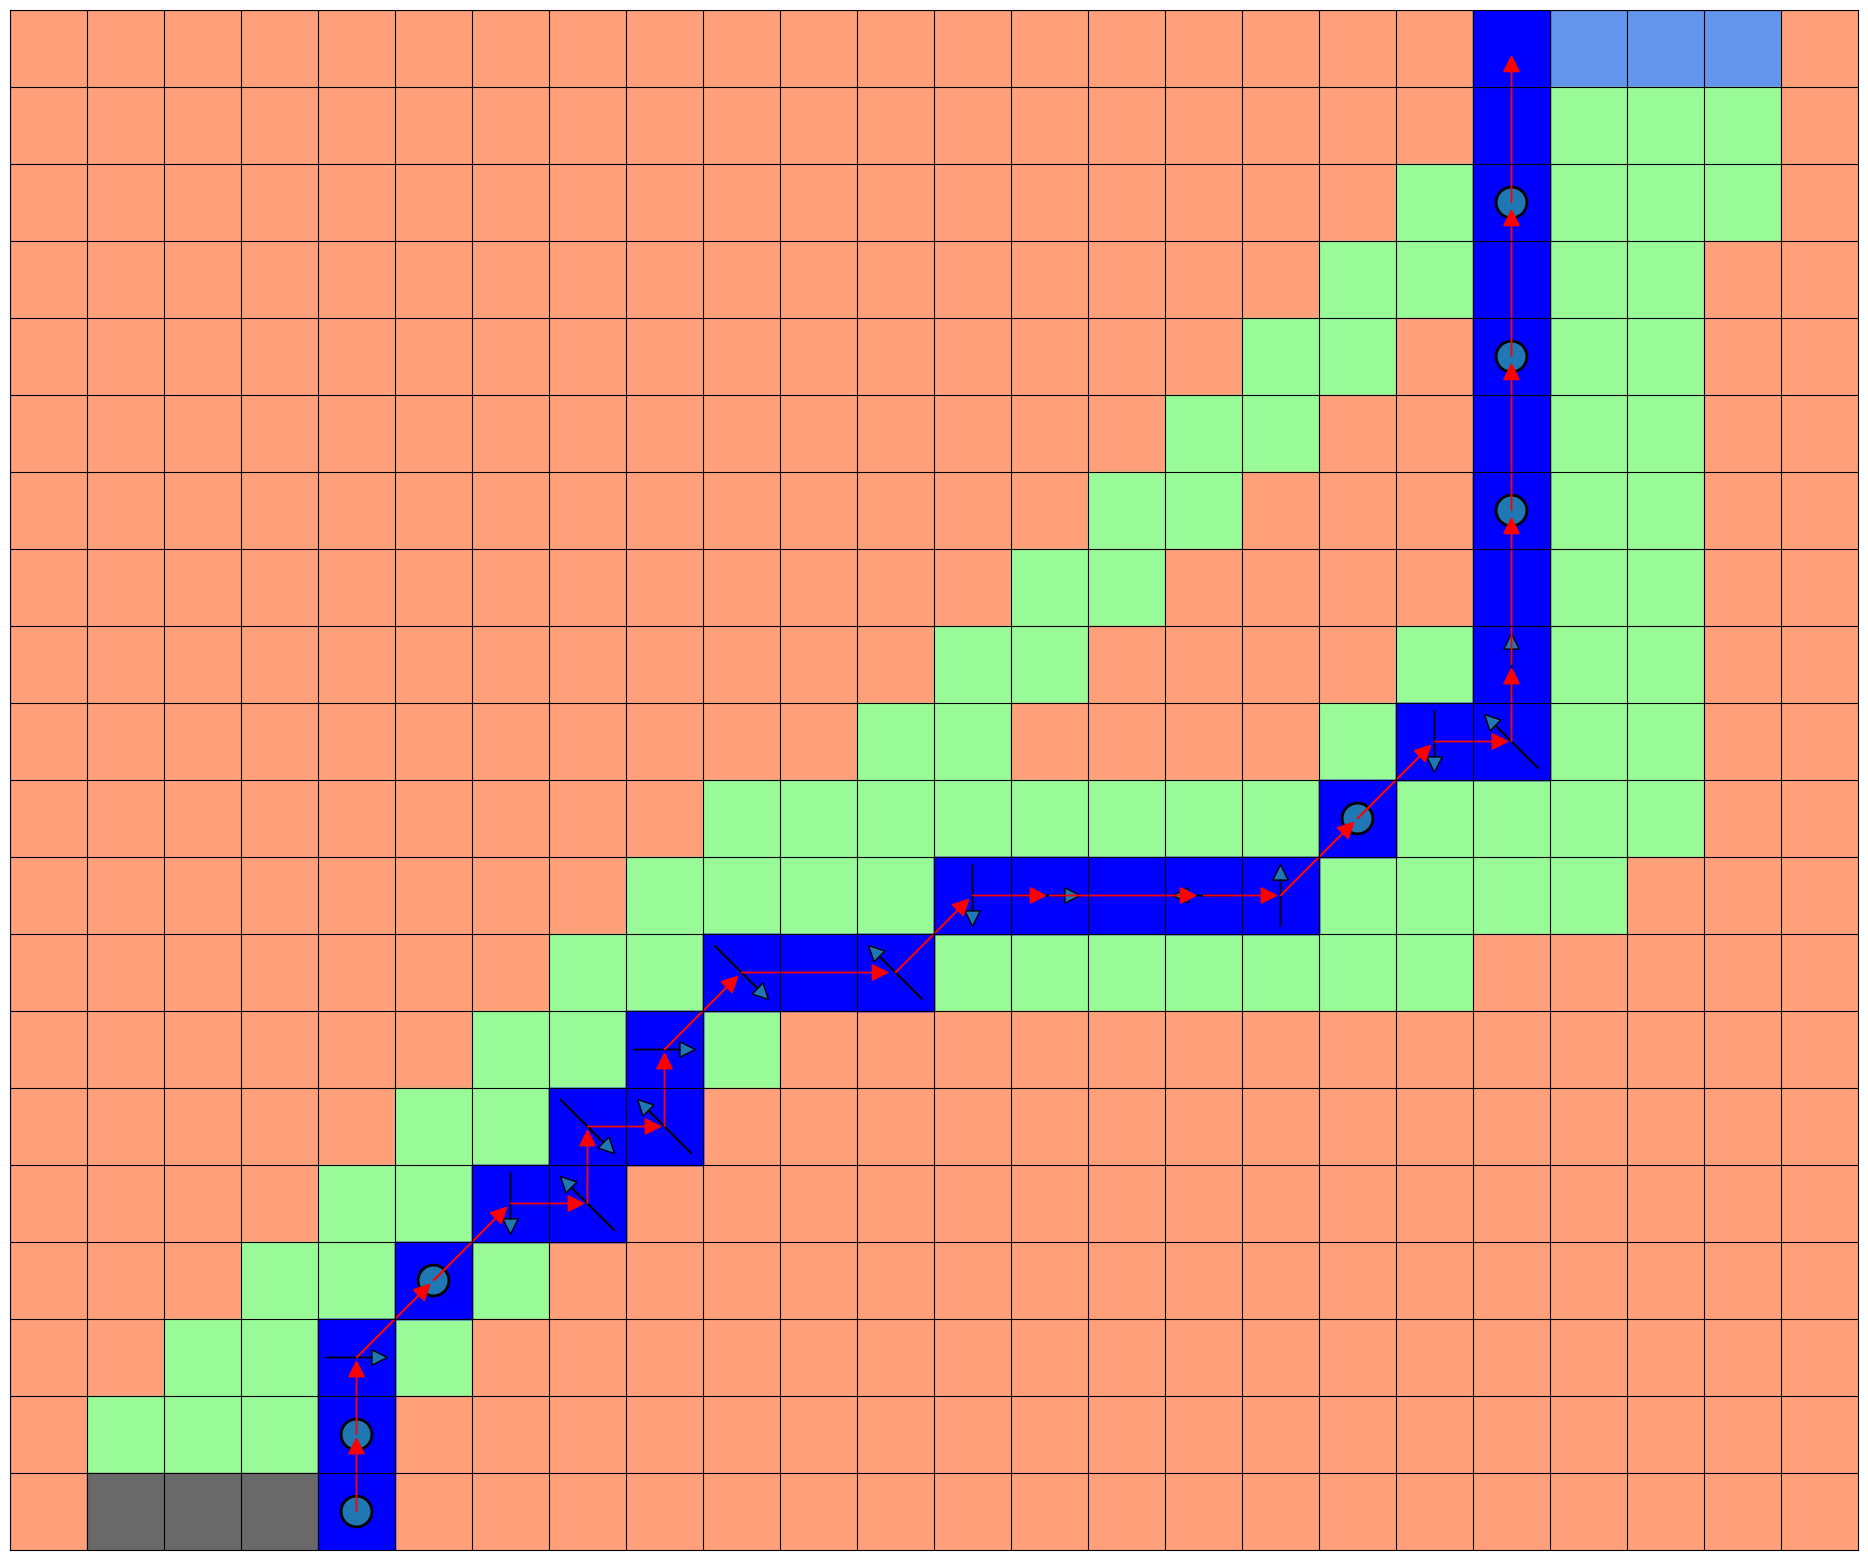

In [14]:
# Continue using Q and policy from previous task
alpha = 0.18
num_episodes = 100000

# Reuse epsilon-greedy function
def epsilon_greedy(state, possible_actions):
    if np.random.rand() < epsilon:
        return np.random.choice(possible_actions)
    q_vals = [Q[(state, a)] for a in possible_actions]
    max_val = max(q_vals)
    best_actions = [a for a, val in zip(possible_actions, q_vals) if val == max_val]
    return np.random.choice(best_actions)

# Run Monte Carlo control with deviation=True
for episode in range(num_episodes):
    racer.reset()
    trajectory = []
    done = False

    while not done:
        state = (*racer.getPosition(), tuple(racer.getVelocity()))
        actions = racer.getAvailableActions()
        action = epsilon_greedy(state, actions)
        y, x, v, r, done, travel = racer.step(action=action, deviation=True)
        trajectory.append((state, action, r))

    # Update Q-values with constant α
    G = 0
    visited = set()
    for state, action, reward in reversed(trajectory):
        G += reward
        if (state, action) not in visited:
            visited.add((state, action))
            Q[(state, action)] += alpha * (G - Q[(state, action)])

# Recompute policy from updated Q
for (state, action), value in Q.items():
    if state not in policy or Q[(state, action)] > Q[(state, policy[state])]:
        policy[state] = action

# Evaluate deterministic trajectories (deviation=False)
startingGrid = [(19, x) for x in np.arange(1, 5)]

for start in startingGrid:
    racer.reset()
    racer.setPosition(*start)
    done = False
    actions = []
    moves = []
    velocities = []

    while not done:
        state = (*racer.getPosition(), tuple(racer.getVelocity()))
        possible_actions = racer.getAvailableActions()
        if state in policy and policy[state] in possible_actions:
            action = policy[state]
        else:
            action = np.random.choice(possible_actions)
        actions.append(action)
        y, x, v, r, done, travel = racer.step(action=action, deviation=False)
        velocities.append(v)
        moves.append(travel)

    drawTrajectory(moves, actions, velocities)
